# Machine Learning: Analysis and Prediction of League of Legend Games

Jordy Berlanger, Computer Scientist (2022)

## Libraries

The libraries that are used in this project will be loaded in here. These provide us handy tools for calculations, data representation, (predictive) data analysis, etc. This way we do not have to implement everything from scratch ourselves.

## The game

League of Legends is a MOBA (multiplayer online battle arena) style of game. Ten players, divided in two teams (blue and red), get to pick champions from an elaborate champion roster and fight against each other. The game can be ended in two ways, namely by destroying the enemy Nexus, or by surrendering once all hope of winning is lost. There are many elements in the game, and the following glossary will explain a few of them.

* **Level**: Champions each have a level ranging from 1 to 18. You level your champion up by defeating enemies, minions or by completing objectives.
* **Towers**: Towers are structures that defend the lanes to the Nexus. These have to be destroyed to ensure a safe lane to the enemy Nexus.
* **Minions**: Minions are non-playable characters that both teams have. Players can kill them to obtain gold.
* **Jungle minions**: Jungle minions are neutral and give gold and statistical advantages to the player or team killing them.
* **Elite monsters**: Elite monsters give statistical advantages to the player or team defeating them.
* **Herald**: The herald is an elite monster that helps the player that defeats it to clear a lane from structures.
* **Dragon**: The dragon is an elite monster that gives the team that defeats it an advantage. One spawns every five minutes, starting from the fifth minute into the game.
* **Warding totem**: An item that can be purchased by a player that will allow the team to see what is happening in the location the totem is planted. Without this totem, fog of war will cover this location and you will not be able to see what is going on unless there is a structure, or your missions are passing through.

These elements all play a role in the outcome of the game and are thus relevant for the analysis and the training of the prediction model.

## The dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

This project will delve into data analysis and prediction for League of Legends games. This means that we will analyse the data of +/- 10.000 League of Legends (diamond rank to low master rank) games to see which factors differ the most between wins and losses. Based on the data of these games, we will also train a model that will predict the outcome of future games with a certain accuracy. The last step will be tweaking parameters of this model, to maximise its accuracy.

The data was downloaded from this [page](https://www.kaggle.com/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min). Thanks for providing it.

In [2]:
# Reading data into a DataFrame using pandas

import pandas as pd
df = pd.read_csv("league_game_data.csv")

# The game ID should not be used for training, so we omit that column
df.drop('gameId', inplace=True, axis=1)

# Print columns of the dataset with their min and max values
print("DATASET INFORMATION:\n")
print(" - Dataset has", len(df), "entries with the following columns.")
print(" - Entries have the following columns:")
print(f"\n\t{'Column':30s} | {'Type':8s} | {'Min':8s} | {'Max':8s}\n")
for col_name in df.columns:
    col = df[col_name]
    print(f"\t{col_name:30s} | {str(col.dtype):8s} | {col.min():8.1f} | {col.max():8.1f}")

DATASET INFORMATION:

 - Dataset has 9879 entries with the following columns.
 - Entries have the following columns:

	Column                         | Type     | Min      | Max     

	blueWins                       | int64    |      0.0 |      1.0
	blueWardsPlaced                | int64    |      5.0 |    250.0
	blueWardsDestroyed             | int64    |      0.0 |     27.0
	blueFirstBlood                 | int64    |      0.0 |      1.0
	blueKills                      | int64    |      0.0 |     22.0
	blueDeaths                     | int64    |      0.0 |     22.0
	blueAssists                    | int64    |      0.0 |     29.0
	blueEliteMonsters              | int64    |      0.0 |      2.0
	blueDragons                    | int64    |      0.0 |      1.0
	blueHeralds                    | int64    |      0.0 |      1.0
	blueTowersDestroyed            | int64    |      0.0 |      4.0
	blueTotalGold                  | int64    |  10730.0 |  23701.0
	blueAvgLevel                   | fl

## Data analysis

In [3]:
# Remove reduntant data, or data that can be derived
blue_columns = ['blueWins', 'blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood', 'blueKills', 'blueDeaths',
                'blueAssists', 'blueEliteMonsters', 'blueDragons', 'blueHeralds', 'blueTowersDestroyed', 'blueTotalGold',
                'blueAvgLevel', 'blueTotalMinionsKilled', 'blueTotalJungleMinionsKilled']
red_columns = ['blueWins', 'redWardsPlaced', 'redWardsDestroyed', 'redFirstBlood', 'redKills', 'redDeaths',
                'redAssists', 'redEliteMonsters', 'redDragons', 'redHeralds', 'redTowersDestroyed', 'redTotalGold',
                'redAvgLevel', 'redTotalMinionsKilled', 'redTotalJungleMinionsKilled']

blue_column_names = ['Win', 'Wards placed', 'Wards destroyed', 'First blood', 'Kills', 'Deaths', 'Assists', 'Elite Monsters',
                    'Dragons', 'Heralds', 'Towers destroyed', 'Total gold', 'Average level', 'Total minions killed',
                    'Total jungle minions killed']
red_column_names = ['Loss', 'Wards placed', 'Wards destroyed', 'First blood', 'Kills', 'Deaths', 'Assists', 'Elite Monsters',
                    'Dragons', 'Heralds', 'Towers destroyed', 'Total gold', 'Average level', 'Total minions killed',
                    'Total jungle minions killed']

df_blue = df[blue_columns]
df_blue.columns = blue_column_names
df_red = df[red_columns]
df_red.columns = red_column_names

In [4]:
df.corr()['blueWins'][:-1].sort_values()

redGoldDiff                    -0.511119
redExperienceDiff              -0.489558
redTotalGold                   -0.411396
redTotalExperience             -0.387588
redAvgLevel                    -0.352127
redKills                       -0.339297
blueDeaths                     -0.339297
redAssists                     -0.271047
redEliteMonsters               -0.221551
redTotalMinionsKilled          -0.212171
redCSPerMin                    -0.212171
redDragons                     -0.209516
redFirstBlood                  -0.201769
redTotalJungleMinionsKilled    -0.110994
redTowersDestroyed             -0.103696
redHeralds                     -0.097172
redWardsDestroyed              -0.055400
redWardsPlaced                 -0.023671
blueWardsPlaced                 0.000087
blueWardsDestroyed              0.044247
blueHeralds                     0.092385
blueTowersDestroyed             0.115566
blueTotalJungleMinionsKilled    0.131445
blueFirstBlood                  0.201769
blueDragons     

PH - You can see everything red contributes impacts blue negatively, except their deaths. This makes sense.

<AxesSubplot:title={'center':'Red team'}>

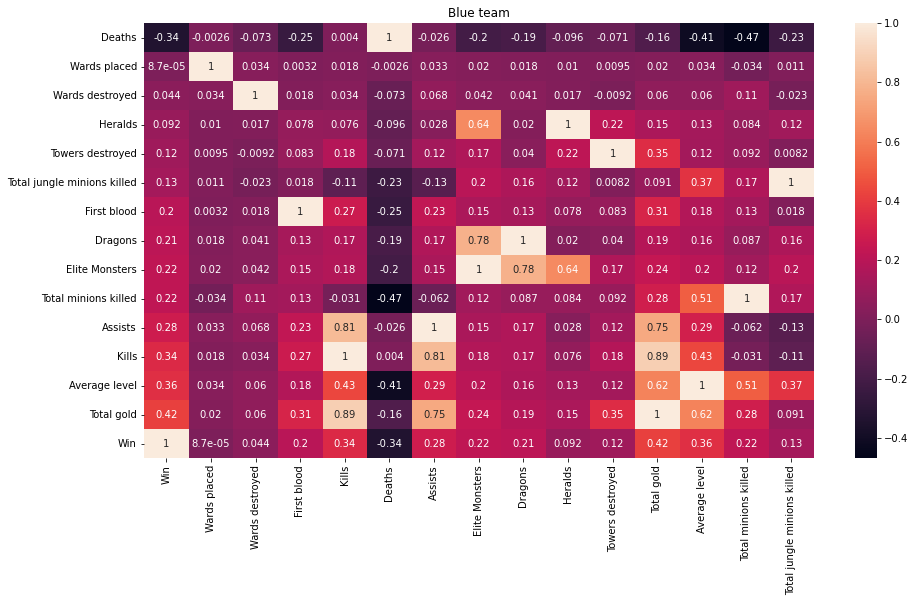

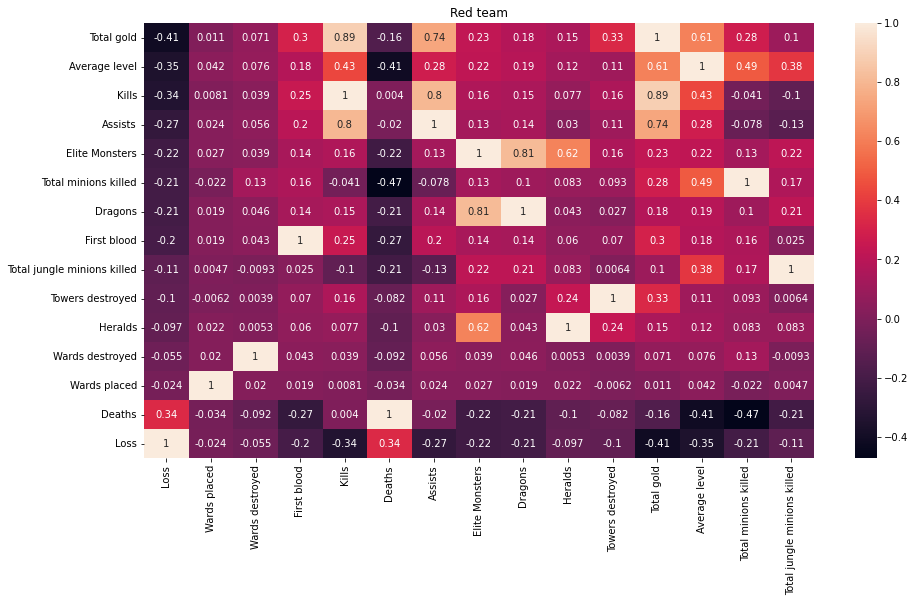

In [5]:
plt.figure(figsize = (15,8))
plt.title("Blue team")
sns.heatmap(df_blue.corr().sort_values(by='Win'), annot = True)
plt.figure(figsize= (15,8))
plt.title("Red team")
sns.heatmap(df_red.corr().sort_values(by='Loss'), annot = True)

PH - No surprising results, except that herald doesn't influence the game as much even though it destroys towers.

## Training data

PH - Now we make the prediction model

### Preprocessing the data

PH - Remove the ones you cannot determine as a player from the game + redundant columns (add explanation why) + the ones with low variance

In [6]:
# Remove reduntant data, or data that can be derived
columns = blue_columns + red_columns[1:]
df = df[columns]

# Give the columns a more human readable name
column_names = ['Win', 'Blue wards placed', 'Blue wards destroyed', 'Blue first blood', 'Blue kills', 'Blue deaths',
                'Blue assists', 'Blue elite Monsters', 'Blue dragons', 'Blue heralds', 'Blue towers destroyed',
                'Blue total gold', 'Blue average level', 'Blue total minions killed','Blue total jungle minions killed',
                'Red wards placed', 'Red wards destroyed', 'Red first blood', 'Red kills', 'Red deaths', 'Red assists',
                'Red lite Monsters', 'Red dragons', 'Red heralds', 'Red towers destroyed', 'Red total gold',
                'Red average level', 'Red total minions killed', 'Red total jungle minions killed']
df.columns = column_names

In [7]:
# We remove the features that have a low variance in their values using VarianceThreshold of SciKit.
sel = VarianceThreshold(threshold = (.8 * (1 - .8)))
sel.fit(df)
# We get the indices of the columns that will be retained because their variance is high enough.
retained_columns = sel.get_support(indices=True)

print("The statistics that have a high enough variance are:")
for i in retained_columns:
    print(f" - {column_names[i]}")
    
# We have a look at what columns are removed as well.
all_columns = [i for i in range(len(df.columns))]
removed_columns = list(set(all_columns) - set(retained_columns))

print("\nThe statistiscs that have too low of a variance are:")
for i in removed_columns:
    print(f" - {column_names[i]}")

The statistics that have a high enough variance are:
 - Win
 - Blue wards placed
 - Blue wards destroyed
 - Blue first blood
 - Blue kills
 - Blue deaths
 - Blue assists
 - Blue elite Monsters
 - Blue dragons
 - Blue total gold
 - Blue total minions killed
 - Blue total jungle minions killed
 - Red wards placed
 - Red wards destroyed
 - Red first blood
 - Red kills
 - Red deaths
 - Red assists
 - Red lite Monsters
 - Red dragons
 - Red total gold
 - Red total minions killed
 - Red total jungle minions killed

The statistiscs that have too low of a variance are:
 - Blue heralds
 - Blue towers destroyed
 - Blue average level
 - Red heralds
 - Red towers destroyed
 - Red average level


### Training the model

In [8]:
test_df_size = 0.2

train_df, test_df = train_test_split(df, test_size=test_df_size)

print("Partitioning of the data:\n")
print(f" - Train data: {len(train_df)} samples ({(1 - test_df_size) * 100}% of the data).")
print(f" - Test data:  {len(test_df)} samples ({test_df_size * 100}% of the data).")

Partitioning of the data:

 - Train data: 7903 samples (80.0% of the data).
 - Test data:  1976 samples (20.0% of the data).
